In [2]:
from aae import aae_model
from tools import MinMaxScaler, DiscrMonitor
from evaluation_model import disc_eva, fore_eva
from networks import timesformer_dec, cnn_enc, cnn_dec, cautrans_dec, discriminator
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.model_selection import train_test_split
import scipy.stats
##
from tensorflow.keras.optimizers import Adam

## Prepare data

In [3]:
dataset = 'sine_cpx'            #use Sine_cpx as an example  
valid_perc = 0.1
train_perc = 1-valid_perc
full_train_data = np.load('datasets/'+dataset+'.npy')
N, T, D = full_train_data.shape

In [4]:
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]
scaler = MinMaxScaler()        
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

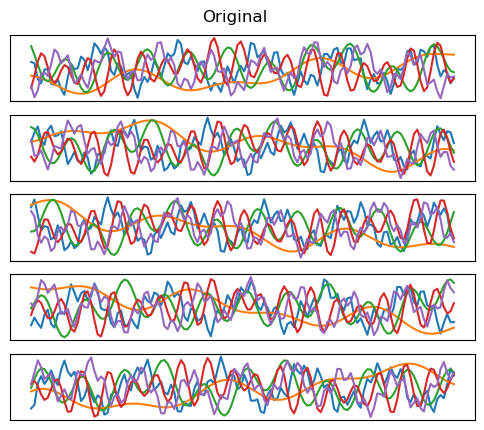

In [5]:
fig, axs = plt.subplots(5, 1, figsize=(6,5), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(x_train))
    s = x_train[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Original')
st.set_y(0.93)

## Build model

In [6]:
ts_shape = x_train.shape[1:]
latent = 16

In [7]:
enc = cnn_enc(
    input_shape=ts_shape,
    latent_dim=latent,
    n_filters=[64, 128, 256],
    k_size=4,
    dropout=0.2
)

dec = timesformer_dec(
    input_shape=latent,
    ts_shape=ts_shape,
    head_size=64,
    num_heads=3,
    n_filters=[128, 64],
    k_size=4,
    dilations=[1,4],
    dropout=0.2
)

disc = discriminator(input_shape=latent, hidden_unit=32)

In [8]:
def ae_loss(ori_ts, rec_ts):
    return tf.keras.metrics.mse(ori_ts, rec_ts)

def dis_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

def gen_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

In [9]:
ae_schedule = PolynomialDecay(initial_learning_rate=0.005, decay_steps=300, end_learning_rate=0.0001, power=0.5)
dc_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)
ge_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)

In [10]:
ae_opt = tf.keras.optimizers.Adam(ae_schedule)
dc_opt = tf.keras.optimizers.Adam(dc_schedule)
ge_opt = tf.keras.optimizers.Adam(ge_schedule)

In [11]:
model = aae_model(
    encoder=enc, 
    decoder=dec, 
    discriminator=disc, 
    latent_dim=latent, 
    dis_steps=1,
    gen_steps=1)

In [12]:
model.compile(rec_opt=ae_opt, rec_obj=ae_loss, dis_opt=dc_opt, dis_obj=dis_loss, gen_opt=ge_opt, gen_obj=gen_loss)

Train model
We provide pre-trained model weights here, you are welcome to change the parameters and play with it. 

In [ ]:
model.load_weights('save_model/sine_cpx/aae_ckp.index') #pre_trained model, to reproduce similar results as paper


In [14]:
history = model.fit(x_train, epochs=800, batch_size=128) #you can train the model from the start here 

Epoch 1/800
36/36 [==============================] - 152s 3s/step - rec_loss: 8.4619 - dis_loss: 0.9581 - gen_loss: 0.8172
Epoch 2/800
36/36 [==============================] - 125s 3s/step - rec_loss: 0.9448 - dis_loss: 0.6885 - gen_loss: 0.6197
Epoch 3/800
36/36 [==============================] - 141s 4s/step - rec_loss: 0.5715 - dis_loss: 0.9124 - gen_loss: 0.5660
Epoch 4/800
36/36 [==============================] - 137s 4s/step - rec_loss: 0.4451 - dis_loss: 0.8153 - gen_loss: 0.5316
Epoch 5/800
36/36 [==============================] - 126s 4s/step - rec_loss: 0.3764 - dis_loss: 1.5861 - gen_loss: 0.4124
Epoch 6/800
36/36 [==============================] - 124s 3s/step - rec_loss: 0.3134 - dis_loss: 1.3752 - gen_loss: 0.5068
Epoch 7/800
36/36 [==============================] - 123s 3s/step - rec_loss: 0.2741 - dis_loss: 0.9702 - gen_loss: 0.6937
Epoch 8/800
36/36 [==============================] - 124s 3s/step - rec_loss: 0.2446 - dis_loss: 1.0873 - gen_loss: 0.6011
Epoch 9/800
36/3

In [15]:
z = tf.random.normal([x_train.shape[0], latent], 0.0, 1.0)
sample = model.dec.predict(z)

141/141 [==============================] - 13s 86ms/step


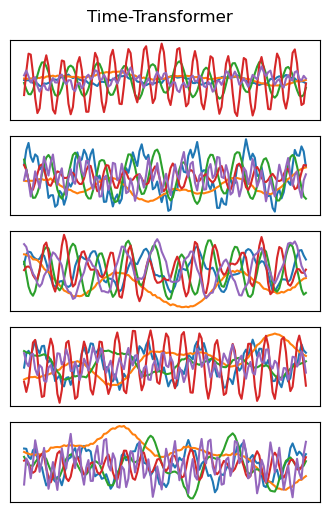

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(4,6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(sample))
    s = sample[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Time-Transformer')
st.set_y(0.93)

## Visualization

In [17]:
train_ori = np.mean(x_train, axis=-1)
train_gen = np.mean(sample, axis=-1)

In [18]:
select = x_train.shape[0]
idx = np.random.permutation(select)
ori = train_ori[idx]
gen = train_gen[idx]
prep_data_final = np.concatenate((ori, gen), axis = 0)

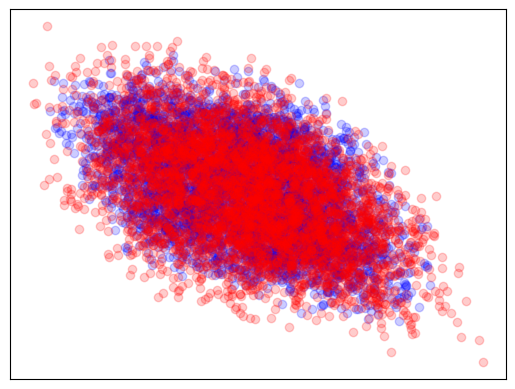

In [19]:
emb = TSNE(n_components=2, learning_rate=10, init = 'random', perplexity=50, n_iter=400).fit_transform(prep_data_final)
plt.yticks([])
plt.xticks([])
plt.scatter(emb[:select, 0], emb[:select, 1], alpha=0.2, color='b')
plt.scatter(emb[select:, 0], emb[select:, 1], alpha=0.2, color='r')

## Discriminative Score

In [20]:
res_d = []
for _ in range(5):  # run 5 times to calculate avg and CI
    x_train_d = np.concatenate((x_train, sample))
    y_train_d = np.append(np.ones(x_train.shape[0]), np.zeros(sample.shape[0]))
    disc_m = disc_eva(input_shape=x_train_d.shape[1:], rnn_unit=[128], dropout=0.3)
    disc_m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    disc_m.fit(x_train_d, y_train_d, epochs=200, batch_size=128, verbose=0)
    
    test_gen = model.dec.predict(tf.random.normal([N_valid, latent], 0.0, 1.0))
    test_ori = x_valid
    x_test_d = np.concatenate((test_ori, test_gen))
    y_test_d = np.append(np.ones(test_ori.shape[0]), np.zeros(test_gen.shape[0]))
    l, acc = disc_m.evaluate(x_test_d, y_test_d)
    res_d.append(np.abs(acc-0.5))
    
print("Max:{}, Min:{}, Avg:{}".format(np.max(res_d), np.min(res_d), np.mean(res_d)))



32/32 [==============================] - 2s 34ms/step - loss: 0.6360 - accuracy: 0.6650
Max:0.48799997568130493, Min:0.14499998092651367, Avg:0.28219999074935914


In [21]:
se = scipy.stats.sem(res_d)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

0.1947026491713765

## Predictive Score

In [22]:
def forecast_data(x): #prepare forecast data
    x = x[:, :-1, :]
    y = x[:, -1, :]
    return x, y

In [23]:
res = []
for _ in range(5): # run 5 times to calculate avg and CI
    x_train_p, y_train_p = forecast_data(sample) # Train on synthetic
    x_test, y_test = forecast_data(x_train) # Test on real
    fore = fore_eva(input_shape=x_train_p.shape[1:], out_shape=x_train_p.shape[-1], rnn_unit=[128])
    fore.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
    fore.fit(x_train_p, y_train_p, epochs=200, batch_size=128, verbose=0)
    res.append(fore.evaluate(x_test, y_test))
print(np.max(res), np.min(res), np.mean(res))

141/141 [==============================] - 6s 36ms/step - loss: 0.0027
0.0036000090185552835 0.0018802013946697116 0.0025102839106693866


In [24]:
se = scipy.stats.sem(res)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

0.0008440094888822262

## Save generated data

In [26]:
np.save('save_model/gen_'+dataset+'.npy', sample)